# Notebook to Demonstrate NISAR Cal/Val Database GPS Access for Greenland Data
---

This demonstrates and tests the capability of the nisarSation class for working with GPS data processed by JPL for NISAR cryo cal/val activities.

## Python Setup

In [33]:
%load_ext autoreload
%autoreload 2
import time
#
reset = False
try:
    import nisarcryodb
except Exception:
    %pip install -e ~/calvalDB/nisarcryodb
    reset = True
try:
    import nisargps
except Exception:
    %pip install -e ~/calvalDB/nisargps
    reset = True
if reset:
    print('\n\033[1;31m\n\nRestart kernel and run this cell again \n\n \033[0m\n''')
    time.sleep(1e9) # stop from advancing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:

import numpy as np
import nisargps
import nisarcryodb
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import pyproj
from scipy.stats import linregress
import calendar
import os

In [35]:
def decimalYearToDateTime(date):
    if date is np.nan:
        return None
    year = int(date)
    fracYear = date - year
    yearLength = (datetime(year + 1, 1, 1) - datetime(year, 1, 1)).total_seconds() 
    return datetime(year, 1, 1) + timedelta(seconds=fracYear * yearLength)

## Load Data

Station data too big for github, so unzip if compressed after downloading.

Setup station id and path.

In [36]:
configFile = '../nisarcryodb/Notebooks/calvaldb_config.ini'

In [37]:
DB = nisarcryodb.nisarcryodb(configFile=configFile)

User name:  irj
Password:  ········


## Find Stations with Data

In [38]:
d1 = 2018.0
d2 = 2030.0
stations = DB.getColumn('landice', 'gps_station', 'station_name')
for station in stations:
    myData = DB.getStationDateRangeData(station, d1, d2, 'landice', 'gps_data')
    minDate = decimalYearToDateTime(np.min(myData['decimal_year']) )
    maxDate = decimalYearToDateTime(np.max(myData['decimal_year']) )
    print(station, len(myData['station_id']), end='\t')
    if minDate is not None:
          print(minDate.strftime('%Y-%m-%d'), maxDate.strftime('%Y-%m-%d'))
    else:
        print('')
    #break


NIL4 0	
NIT3 0	
NIU4 0	
NIL2 0	
NIL1 0	
NIT4 0	
NIU3 0	
NIT0 0	
NIT2 0	
LORG 3600	2019-10-25 2019-10-27
NIU1 262080	2024-05-01 2024-07-31
NIU5 0	
NIT1 0	
NIL3 0	
NIT5 0	
test 0	
NIL5 0	
NIU2 0	


## Setup NIU1

Pass in the already open DB rather than having the station open its own DB connection

In [39]:
stationName = 'NIU1'
stationNIU1 = nisargps.nisarStation(stationName, DBConnection=DB, traceBack=False)

Load a sample data set. Can be accessed as `stationNIU1.x` (or `.y, .z, .lat, .lon, .date, .epoch`), where `date` provides the date as `datetime` array and `epoch` provides the date as a decimal year.

In [40]:
data = stationNIU1.subsetXYZ('2024-01-01 21:01:01', '2024-12-27 03:59:59', dateFormat='%Y-%m-%d %H:%M:%S', minPoints=1, traceBack=True)

EPSG 3413


## Plot Positions

Plot early January trajectory. 

0.027323708846213882 0.024242800337395554


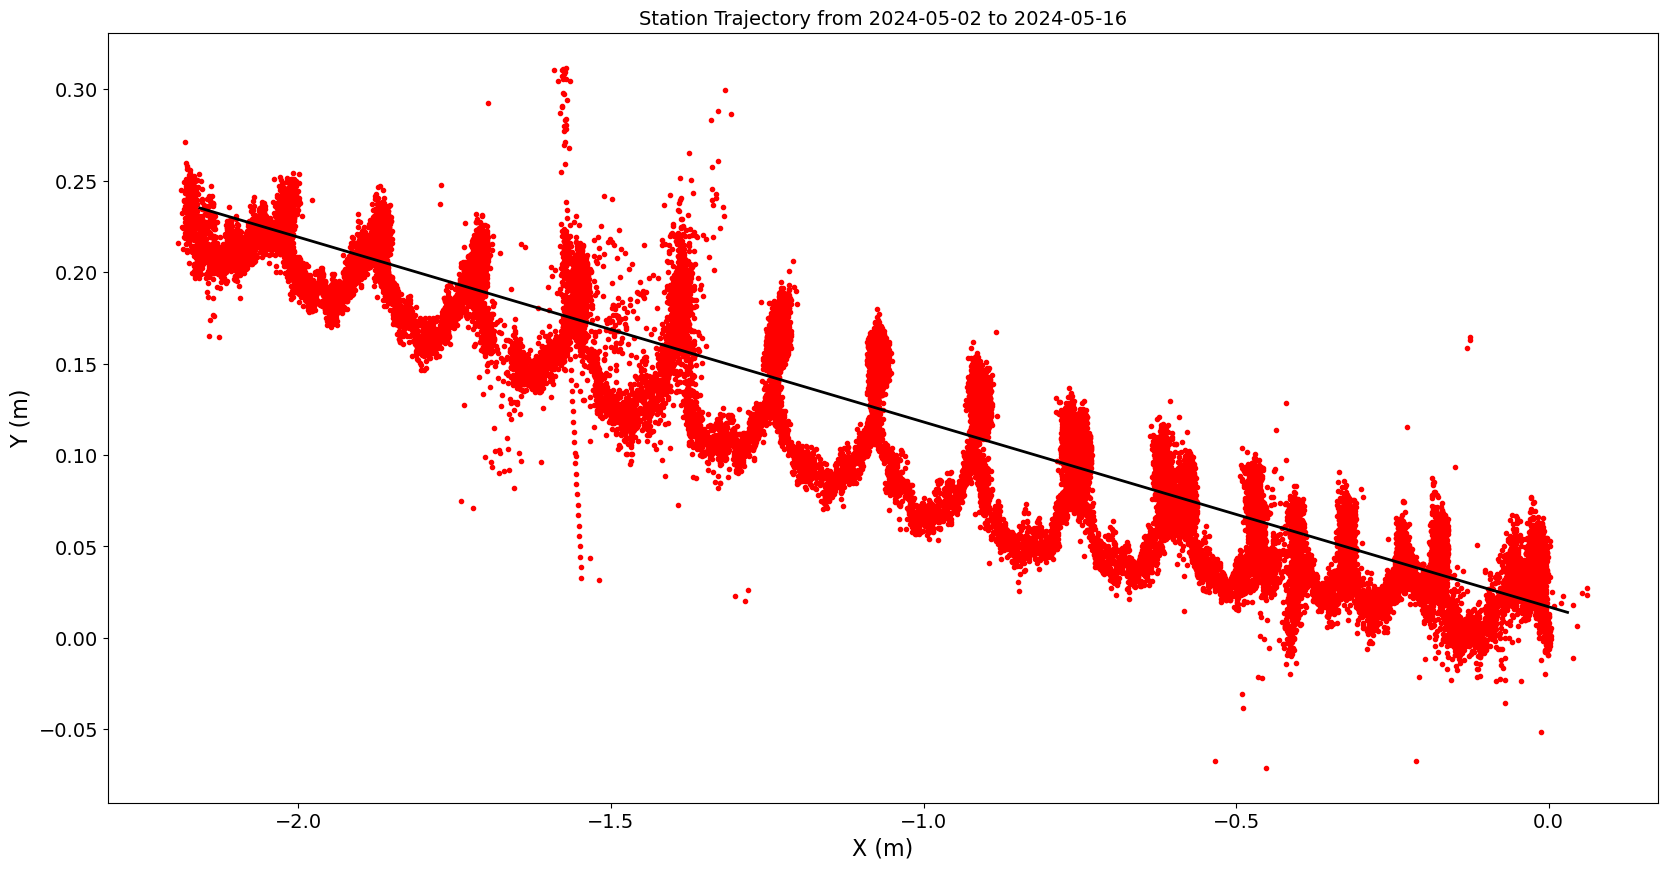

In [41]:
date, x, y, z, epoch = stationNIU1.subsetXYZ('2024-05-01 21:01:01', '2024-05-16 03:59:59', sigmaMultiple=3)
minDate = np.min(date).strftime('%Y-%m-%d')
maxDate = np.max(date).strftime('%Y-%m-%d')

resultx = linregress(epoch, x)
resulty = linregress(epoch, y)
# Compute linear path
xline = resultx[0] * epoch + resultx[1]
yline = resulty[0] * epoch + resulty[1]
print(np.std(x-xline), np.std(y-yline))
#
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(x -x[0], y - y[0], 'r.')
ax.plot(xline-x[0], yline-y[0], 'k', linewidth=2)
ax.set_xlabel('X (m)', fontsize=16)
ax.set_ylabel('Y (m)', fontsize=16)
ax.set_title(f'Station Trajectory from {minDate} to {maxDate}', fontsize=14) 
for lab  in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontsize(14)

## Compute and Plot Time Series

This section demonstrates the estimate of a velocity time series over a given period. There are two methods:
- `point`, which computes the position averaged over some interval (`averagingPeriod`)
- `regression` this method computes the velocity of slope for all the points over the period of interest.

The method is specified with the `method` keyword. Either method generates the series from `date1` to `date2`, sampled at increments of `sampleInterval` hours. Velocities are computed with a `dT` specfied in hours. Further research is needed to best determine the velocity for NISAR cal/val. In this example, the standard deviations of the velocities computed using the two methods are 0.6 and 1.7 m/yr, respectively. The differences arise because of the large diurnal variation in speed on the floating ice. The results should be much better on grounded ice. 

The method and period are specified as:

In [42]:
#method = 'point'
method = 'regression'
date1 = '2024-05-01' 
date2 = '2024-07-31'

Compute velocity at various intervals and over various periods.

Compute velocity time series at daily intervals.

In [43]:
sampleInterval = 6 # Estimate every 4 hours
dT = 24  # Compute over a 24 hour interval
dateDaily, vxDaily, vyDaily = stationNIU1.computeVelocityTimeSeries(date1, date2,
                                                                    dT, sampleInterval, method=method)
print(f'Sigma X, Y {np.nanstd(vxDaily):.3} (m), {np.nanstd(vyDaily):.3} (m)')

Sigma X, Y 18.6 (m), 14.5 (m)


Now compute at daily intervals but with delta T of 12 days.

In [44]:
sampleInterval = 12 # Estimate every 12 hours
dT = 24 * 12  # Compute speed over 12 day interval
date12, vx12, vy12 = stationNIU1.computeVelocityTimeSeries(date1, date2,
                                                           dT, sampleInterval, method=method)
print(f'Sigma X, Y {np.nanstd(vx12):.3}, {np.nanstd(vy12):.3}')

Sigma X, Y 0.205, 0.331


Now Plot the results.

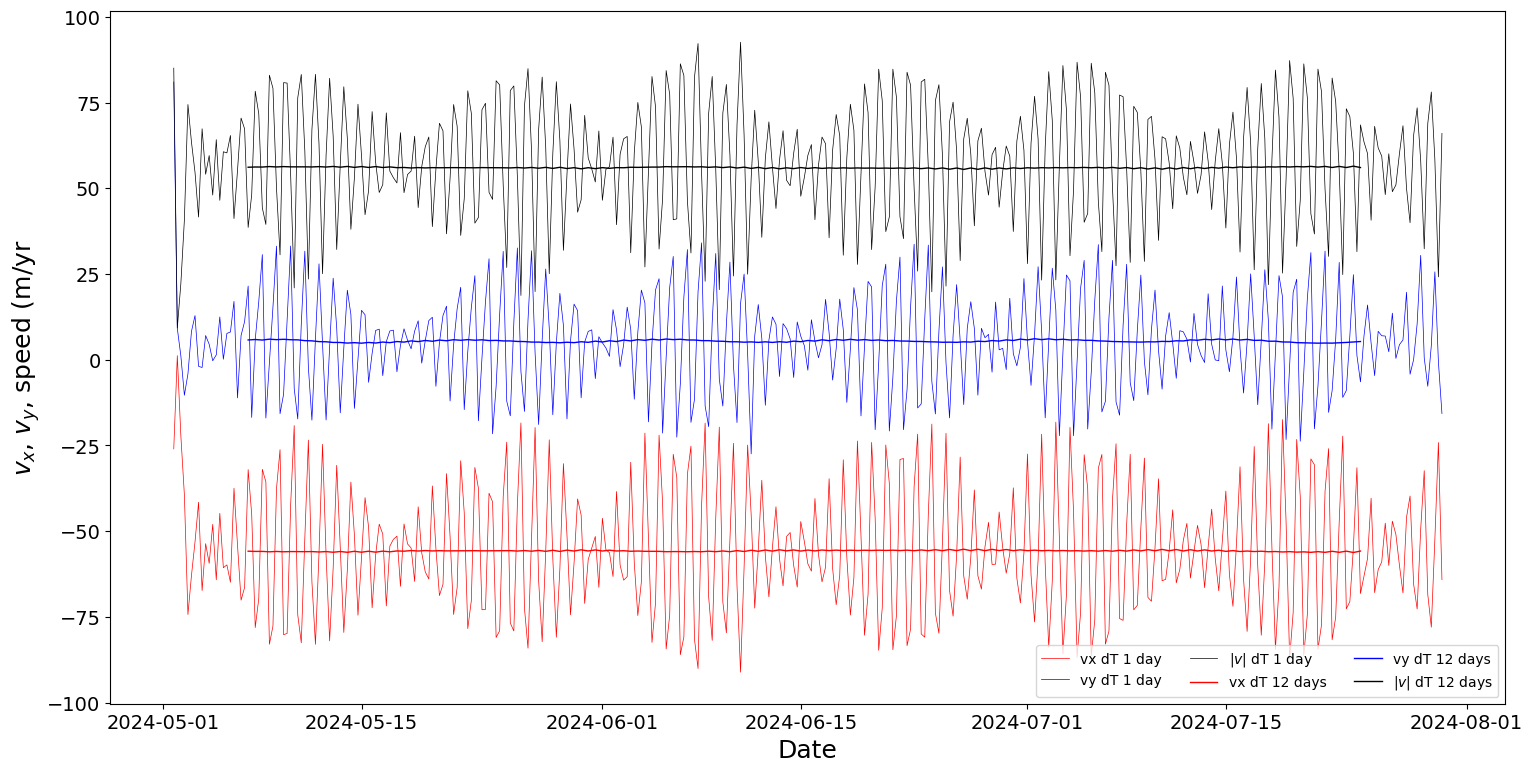

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for date, vx, vy, dTLabel, marker, linewidth in zip([ dateDaily, date12],
                                         [ vxDaily, vx12], 
                                         [ vyDaily, vy12],
                                         ['dT 1 day', 'dT 12 days'], 
                                         ['-', '-', 'o'], [.5, 1, 1]):
    ax.plot(date, vx, f'r{marker}', label=f'vx {dTLabel}', markersize=4, linewidth=linewidth)
    ax.plot(date, vy, f'b{marker}', label=f'vy {dTLabel}', markersize=4, linewidth=linewidth)
    ax.plot(date, np.sqrt(vx**2 + vy**2), f'k{marker}', label=f'$|v|$ {dTLabel}', markersize=4, linewidth=linewidth)
#
ax.set_ylabel('$v_x$, $v_y$, speed (m/yr', fontsize=18)  
ax.set_xlabel('Date', fontsize=18)
for lab  in ax.get_xticklabels() + ax.get_yticklabels():
    lab.set_fontsize(14)
ax.legend(loc='lower right', ncol=3)

As the results indicate, there is there is a large diurnal variation for the daily solutions, which are probably some kind of time. Needs confirmation and checking to see if the error can be reduced. The 12-day estimates are quite stable with $\sigma$ of ~30 cm/yr. 